In [26]:

import pandas as pd, numpy as np, simpy, networkx as nx
from sklearn.cluster import KMeans
from tqdm import tqdm

# ---------- 0. 参数 ----------
GRID_X, GRID_Y, GRID_Z       = 50, 50, 3            # 仓库网格尺寸
N_SLOTS              = GRID_X * GRID_Y * GRID_Z   # one slot per walkable cell
N_SKU                = 1000              # 一共有 1000 个SKU
ORDER_LAMBDA         = 2/60              # 2 单 / 分钟  ➜ 120 单/时  (Poisson) :contentReference[oaicite:10]{index=10}
ABC_SPLIT            = (.1, .2, .7)      # A/B/C SKU比例 :contentReference[oaicite:12]{index=12}
ABC_QTY              = ((120,480),(30,120),(1,30))    # 初始件数 A/B/C的区间
FORKLIFT_RATIO       = 0.15              # 需要叉车的 slot 比例
N_PICKERS            = 6
WALK_SPEED           = 1                 # 1 格 / s
PICK_TIME            = 5                 # 5 s / 件
LOAD_TIME            = 8                 # 装车
ROP_DAYS             = 0.5               # 安全库存天数 (简化)
LEAD_TIME_MEAN       = 2*60*60           # 2 h
RNG                  = np.random.default_rng(42) #创建受控随机流，保证结果可复现；42 只是惯用示例种子。


In [27]:
# ---------- 1. 生成货位 ----------
x, y, z = np.meshgrid(np.arange(GRID_X), np.arange(GRID_Y), np.arange(GRID_Z))
slots = (pd.DataFrame({'slot_id': np.arange(N_SLOTS),
                       'x': x.flatten(),
                       'y': y.flatten(),
                       'z': z.flatten(), #将一个三维坐标网络的坐标转换为一维数组
                       'max_weight':(4-z.flatten())*1000, #kg
                       'max_height': 150,#cm
                       'max_width': 150,#cm
                       'max_depth': 150,#cm
                       }))
slots.to_csv("slots.csv", index=False)

In [28]:

from scipy.stats import truncnorm

# ---------- 2. 生成 SKU 主数据 ----------
# 生成一个 DataFrame，对应 0 ~ N_SKU-1 的 SKU 编号
sku_df = pd.DataFrame({'sku_id': np.arange(N_SKU)})
# 按 ABC 分类规则，把 sku_id 划分为 A / B / C 三类
# - bins 指定分段的“右开区间”：(-1, A_end]、(A_end, B_end]、(B_end, N_SKU]
#   · A_end = N_SKU * ABC_SPLIT[0]   → 例如 20%
#   · B_end = N_SKU * (0.2 + 0.3)    → 例如再加 30%
# - labels 给这三段区间分别贴上 'A' 'B' 'C' 标签
sku_df['class'] = pd.cut(sku_df['sku_id'],
                         bins=[-1, int(N_SKU*ABC_SPLIT[0]),
                               int(N_SKU*(ABC_SPLIT[0]+ABC_SPLIT[1])), N_SKU],
                         labels=['A','B','C'])

# 根据分类结果给每个 SKU 指定“初始库存数量”
# - A 类配 ABC_QTY[0]（高周转，高库存）
# - B 类配 ABC_QTY[1]
# - C 类配 ABC_QTY[2]（长尾，低库存）
height_list=[]
length_list=[]
width_list=[]
number_list=[]

lower=5
upper=125
loc=10
scale=30
a=(lower-loc)/scale
b=(upper-loc)/scale

for _ in range(N_SKU):
    height=np.clip(truncnorm(a,b,loc=loc,scale=scale).rvs(1),5,120)
    height_list.append(height)
    length=np.clip(truncnorm(a,3*height,loc=height,scale=scale).rvs(1),5,120)
    length_list.append(length)
    width=np.clip(truncnorm(a,3*height,loc=height,scale=scale).rvs(1),5,120)
    width_list.append(width)

for i in sku_df['class']:
    if i=='A':
        number_list.append(np.random.randint(ABC_QTY[0][0],ABC_QTY[0][1]))
    elif i=='B':
        number_list.append(np.random.randint(ABC_QTY[1][0],ABC_QTY[1][1]))
    else:
        number_list.append(np.random.randint(ABC_QTY[2][0],ABC_QTY[2][1]))
        

sku_df['height']=np.array(height_list).astype(int)
sku_df['length']=np.array(length_list).astype(int)
sku_df['width']=np.array(width_list).astype(int) #长宽高在 5～120 cm 之间

sku_df['volumn']=sku_df['height']/100*sku_df['length']/100*sku_df['width']/100 #体积立方米
sku_df['number']=np.array(number_list).astype(int)

sku_density=RNG.triangular(left=50,mode=400,right=2000,size=N_SKU) #密度在 0.05～4 之间

sku_df['weight']=sku_density*sku_df['volumn'] # 重量在 50g～500kg 之间
sku_df['weight']=np.clip(sku_df['weight'],0.05,2000)
# 把最终的 SKU 主数据表写出为 CSV 文件（不保存行索引）
sku_df.to_csv("sku_master.csv", index=False)


In [29]:
# ---------- 3. 初始库存分配 & slotting ----------
sku_df=pd.read_csv("sku_master.csv") #读取 sku 主数据表
slots_df=pd.read_csv("slots.csv") #读取货位数据表
sku_df.columns
#slots_df.columns
assigned_slots_df=pd.DataFrame(columns=['slot_id','x','y','z','sku_id','number'])


In [30]:

# 往每一个货架内随机分配 sku
# 分配策略：
# 1. 从第一个 SKU 开始，从第一个货架开始找位置，如果货架没有位置，则找下一个货架，直到把东西放满位置，如果没放满，还是会单独放一个格子
assigned_slots=[]
slot_id=0
for i,sku in sku_df.iterrows():
    print(f"sku: {sku['sku_id']}")
    remaining_number=sku['number'] #还剩这些数量

    while remaining_number>0:
        assigned_slot=[]
        print("Remaining number:",remaining_number)
        slot=slots_df.loc[slot_id] #从第一行取
        # 先把货架的位置和 id取出来
        assigned_slot.append(slot['slot_id'])
        assigned_slot.append(slot['x'])
        assigned_slot.append(slot['y'])
        assigned_slot.append(slot['z'])
        print(f"assigned_slot id:{assigned_slot[0]},x:{assigned_slot[1]},y:{assigned_slot[2]},z:{assigned_slot[3]}")
        assigned_slot.append(sku['sku_id'])

        number_by_volumn=(slot['max_height']//sku['height'])*(slot['max_width']//sku['width'])*(slot['max_depth']//sku['length']) #计算按照体积计算货架可以放多少个sku,向下取整
        number_by_weight=slot['max_weight']//sku['weight'] #计算按照重量计算货架可以放多少个sku,向下取整
        number=min(number_by_volumn,number_by_weight) #计算货架可以放多少个sku,取最小值
        print(f"item_height: {sku['height']},item_length: {sku['length']},item_width: {sku['width']}")
        print(f"slot_height: {slot['max_height']},slot_length: {slot['max_depth']},slot_width: {slot['max_width']}")
        print(f"number_by_volumn: {number_by_volumn}")
        print(f"number_by_weight: {number_by_weight}")
        print(f"number_on_this_slot: {number}")
        print(f"class: {sku['class']}")
        
        assigned_slot.append(number) #把货架可以放多少个sku写进去
        assigned_slot.append(sku['class'])

        slot_id=slot_id+1
        remaining_number=remaining_number-number #计算这个 sku 还有多少没放

        assigned_slots.append(assigned_slot)
    print(f"assigned_slots number: {len(assigned_slots)}")
    print(f"slots percentage: {(len(assigned_slots)/N_SLOTS)*100}%")

columns=['slot_id','x','y','z','sku_id','number','class']
assigned_slots_df=pd.DataFrame(assigned_slots,columns=columns)
assigned_slots_df.to_csv("assigned_slots.csv",index=False)
assigned_slots_df.head()



sku: 0
Remaining number: 358
assigned_slot id:0,x:0,y:0,z:0
item_height: 68,item_length: 77,item_width: 76
slot_height: 150,slot_length: 150,slot_width: 150
number_by_volumn: 2
number_by_weight: 8.0
number_on_this_slot: 2
class: A
Remaining number: 356
assigned_slot id:1,x:0,y:0,z:1
item_height: 68,item_length: 77,item_width: 76
slot_height: 150,slot_length: 150,slot_width: 150
number_by_volumn: 2
number_by_weight: 6.0
number_on_this_slot: 2
class: A
Remaining number: 354
assigned_slot id:2,x:0,y:0,z:2
item_height: 68,item_length: 77,item_width: 76
slot_height: 150,slot_length: 150,slot_width: 150
number_by_volumn: 2
number_by_weight: 4.0
number_on_this_slot: 2
class: A
Remaining number: 352
assigned_slot id:3,x:1,y:0,z:0
item_height: 68,item_length: 77,item_width: 76
slot_height: 150,slot_length: 150,slot_width: 150
number_by_volumn: 2
number_by_weight: 8.0
number_on_this_slot: 2
class: A
Remaining number: 350
assigned_slot id:4,x:1,y:0,z:1
item_height: 68,item_length: 77,item_width: 

,slot_id,x,y,z,sku_id,number,class
0,0,0,0,0,0,2.0,A
1,1,0,0,1,0,2.0,A
2,2,0,0,2,0,2.0,A
3,3,1,0,0,0,2.0,A
4,4,1,0,1,0,2.0,A


In [31]:
# ---------- 4. 订单生成 ----------
ZIPF_A               = 1.2               # Zipf 分布参数 (长尾) :contentReference[oaicite:11]{index=11}
SIM_TIME             = 24*60*60           # 24 h
def gen_order_id(i): return f"O{i:05d}"
orders = []
t = 0.0
order_idx = 0
while t < SIM_TIME:
    # Poisson inter-arrival
    t += RNG.exponential(1/ORDER_LAMBDA)#
    # 抽取行数（订单行） 1–5
    n_lines =int(np.random.normal(loc=5.0, scale=2.0)+3)
    # SKU 列表按 Zipf 抽样
    skus = RNG.zipf(a=ZIPF_A, size=n_lines) % N_SKU
    # waiting time
    waiting_time = RNG.choice([3*60*60, 6*60*60, 12*60*60], p=[0.3,0.5,0.2])
    orders.append({'order_id': gen_order_id(order_idx),
                   'create_ts': t,
                   'sku_list': list(map(int, skus)),
                   'waiting_time': int(waiting_time)})
    order_idx += 1
orders = pd.DataFrame(orders)
orders.to_csv("orders.csv",index=False)
orders.head()

,order_id,create_ts,sku_list,waiting_time
0,O00000,1.426527,"[21, 2, 21, 97, 742]",10800
1,O00001,10.164663,"[496, 13, 577, 281, 182, 13, 1, 229, 7, 4]",10800
2,O00002,29.203733,"[2, 3, 110, 135, 965, 324, 111, 6]",21600
3,O00003,51.285074,"[7, 322, 21, 176, 4, 13]",43200
4,O00004,78.843824,"[2, 255, 704, 2, 15, 1, 484, 1, 2]",21600


In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, deque
import random

# 嵌套Logit模型计算类
class NestedLogitModel:
    def __init__(self, lambda_param=0.4):
        """
        初始化嵌套Logit模型
        Args:
            lambda_param: 嵌套参数λ，控制巢内相关性
        """
        self.lambda_param = lambda_param
        
    def compute_nest_iv(self, nest_tasks, utilities):
        """
        计算巢的包容值(Inclusive Value)
        Args:
            nest_tasks: 巢内的任务ID列表
            utilities: 任务效用字典 {task_id: utility}
        Returns:
            巢的包容值IV
        """
        if not nest_tasks:
            return float('-inf')  # 空巢返回负无穷
            
        # 计算IV = ln(∑(exp(U/λ)))
        sum_exp_u = sum(np.exp(utilities[t] / self.lambda_param) for t in nest_tasks)
        if sum_exp_u == 0:
            return float('-inf')
        return np.log(sum_exp_u)
    
    def compute_nest_probabilities(self, nest_ivs):
        """
        计算选择每个巢的概率
        Args:
            nest_ivs: 巢的包容值字典 {nest_name: iv_value}
        Returns:
            巢选择概率字典 {nest_name: probability}
        """
        exp_iv_lambda = {nest: np.exp(self.lambda_param * iv) for nest, iv in nest_ivs.items()}
        sum_exp_iv = sum(exp_iv_lambda.values())
        
        if sum_exp_iv == 0:
            # 如果所有巢都为空或效用极低，返回均匀分布
            nests = list(nest_ivs.keys())
            return {nest: 1.0/len(nests) for nest in nests}
            
        return {nest: exp_iv_lambda[nest] / sum_exp_iv for nest in exp_iv_lambda}
    
    def compute_conditional_probabilities(self, nest_tasks, utilities):
        """
        计算巢内条件概率P(t|nest)
        Args:
            nest_tasks: 巢内任务ID列表
            utilities: 任务效用字典
        Returns:
            巢内条件概率字典 {task_id: probability}
        """
        if not nest_tasks:
            return {}
            
        # 计算exp(U/λ)
        exp_u_lambda = {t: np.exp(utilities[t] / self.lambda_param) for t in nest_tasks}
        sum_exp_u = sum(exp_u_lambda.values())
        
        if sum_exp_u == 0:
            # 均匀分布
            return {t: 1.0/len(nest_tasks) for t in nest_tasks}
            
        return {t: exp_u_lambda[t] / sum_exp_u for t in nest_tasks}
    
    def compute_task_probabilities(self, tasks_by_nest, utilities):
        """
        计算所有任务的最终选择概率
        Args:
            tasks_by_nest: 按巢分类的任务 {nest_name: [task_ids]}
            utilities: 任务效用字典 {task_id: utility}
        Returns:
            任务选择概率字典 {task_id: probability}
        """
        # 1. 计算每个巢的包容值IV
        nest_ivs = {nest: self.compute_nest_iv(tasks, utilities) 
                   for nest, tasks in tasks_by_nest.items()}
        
        # 2. 计算选择每个巢的概率
        nest_probs = self.compute_nest_probabilities(nest_ivs)
        
        # 3. 计算每个巢内任务的条件概率
        conditional_probs = {}
        for nest, tasks in tasks_by_nest.items():
            conditional_probs.update({t: self.compute_conditional_probabilities(tasks, utilities).get(t, 0) 
                                     for t in tasks})
        
        # 4. 计算每个任务的最终概率 P(t) = P(nest) * P(t|nest)
        task_probs = {}
        for nest, tasks in tasks_by_nest.items():
            for t in tasks:
                nest_prob = nest_probs.get(nest, 0)
                cond_prob = conditional_probs.get(t, 0)
                task_probs[t] = nest_prob * cond_prob
                
        return task_probs

In [33]:
class ManagerAgent(nn.Module):
    def __init__(self, state_dim, feature_dim=5, hidden_dim=64, lr=0.001):
        """
        初始化经理智能体
        Args:
            state_dim: 状态空间维度
            feature_dim: 任务特征维度
            hidden_dim: 隐藏层维度
            lr: 学习率
        """
        super(ManagerAgent, self).__init__()
        self.state_dim = state_dim
        self.feature_dim = feature_dim
        self.combined_dim = state_dim + feature_dim
        
        # 价值网络
        self.value_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        # 效用调整网络 - 修改这里的输入维度
        self.utility_network = nn.Sequential(
            nn.Linear(self.combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.nl_model = NestedLogitModel(lambda_param=0.4)
        self.memory = deque(maxlen=1000)
        self.gamma = 0.99
        
    def compute_base_utilities(self, tasks):
        """
        计算任务基础效用
        Args:
            tasks: 任务列表
        Returns:
            任务效用字典
        """
        # 这里简化实现，实际应用中可根据任务属性计算基础效用
        utilities = {}
        for task in tasks:
            # 如任务为标准任务，基础效用为5；特殊处理任务，基础效用为4
            base_utility = 5 if task['nest'] == 'A' else 4
            
            # 可以考虑其他因素如:
            # - 任务优先级
            # - 距离
            # - 预计耗时等
            
            utilities[task['id']] = base_utility
        return utilities
        
    def adjust_utilities(self, state, base_utilities, tasks):
        """
        使用RL调整任务效用
        Args:
            state: 当前状态
            base_utilities: 基础效用
            tasks: 任务列表
        Returns:
            调整后的效用
        """
        adjusted_utilities = {}
        state_tensor = torch.FloatTensor(state)
        
        for task in tasks:
            task_id = task['id']
            # 修改这一行，确保张量维度匹配
            task_features = torch.FloatTensor(task['features'])  # 直接转换为一维张量
            task_state = torch.cat([state_tensor, task_features], dim=0)
            utility_adjustment = self.utility_network(task_state).item()
            
            # 调整基础效用
            adjusted_utilities[task_id] = base_utilities[task_id] + utility_adjustment
            
        return adjusted_utilities
        
    def select_task(self, state, available_tasks):
        """
        为拣选员选择任务
        Args:
            state: 当前状态
            available_tasks: 可用任务列表，每个任务包含{'id', 'nest', 'features'...}
        Returns:
            选中的任务ID
        """
        # 按巢分类任务
        tasks_by_nest = defaultdict(list)
        for task in available_tasks:
            tasks_by_nest[task['nest']].append(task['id'])
            
        # 计算基础效用
        base_utilities = self.compute_base_utilities(available_tasks)
        
        # 通过RL来调整效用
        adjusted_utilities = self.adjust_utilities(state, base_utilities, available_tasks)
        
        # 使用嵌套Logit计算任务选择概率
        task_probs = self.nl_model.compute_task_probabilities(tasks_by_nest, adjusted_utilities)
        
        # 策略选择：可以是贪婪策略或概率采样
        if random.random() < 0.1:  # 探索率
            # 探索：按概率采样
            tasks = list(task_probs.keys())
            probs = list(task_probs.values())
            return np.random.choice(tasks, p=probs)
        else:
            # 利用：选择概率最高的任务
            return max(task_probs.items(), key=lambda x: x[1])[0]
    
    def remember(self, state, action, reward, next_state, done):
        """
        存储经验到回放缓冲区
        """
        self.memory.append((state, action, reward, next_state, done))
    
    def train(self, batch_size=32):
        """
        训练智能体
        """
        if len(self.memory) < batch_size:
            return
            
        # 从经验回放中抽样
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # 转换为张量
        states = torch.FloatTensor(states)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # 计算目标值
        current_values = self.value_network(states).squeeze()
        next_values = self.value_network(next_states).squeeze()
        target_values = rewards + self.gamma * next_values * (1 - dones)
        
        # 计算损失
        loss = nn.MSELoss()(current_values, target_values.detach())
        
        # 优化
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

In [34]:
class PickerAgent:
    def __init__(self, picker_id):
        """
        初始化拣选员智能体
        Args:
            picker_id: 拣选员ID
        """
        self.id = picker_id
        self.current_task = None
        self.position = (0, 0)  # 初始位置
        self.busy_until = 0     # 忙碌截止时间
        
    def is_idle(self, current_time):
        """
        判断拣选员是否空闲
        """
        return current_time >= self.busy_until
        
    def assign_task(self, task, current_time):
        """
        分配任务给拣选员
        Args:
            task: 任务信息
            current_time: 当前时间
        Returns:
            任务预计完成时间
        """
        self.current_task = task
        
        # 计算任务实际耗时
        duration = self.calculate_task_duration(task)
        
        # 设置忙碌截止时间
        self.busy_until = current_time + duration
        
        return self.busy_until
    
    def calculate_task_duration(self, task):
        """
        计算任务实际执行时间
        Args:
            task: 任务信息
        Returns:
            执行时间（单位：秒）
        """
        # 简化实现，根据任务类型、距离等计算耗时
        base_time = 60  # 基础时间（秒）
        
        # 特殊处理任务耗时更长
        if task['nest'] == 'B':  # 特殊处理任务
            base_time *= 1.5
            
        # 考虑距离因素
        distance = self.calculate_distance(task['location'])
        travel_time = distance * 2  # 假设每单位距离需要2秒
        
        return base_time + travel_time
    
    def calculate_distance(self, target_location):
        """
        计算从当前位置到目标位置的距离
        """
        # 简单的曼哈顿距离
        return abs(self.position[0] - target_location[0]) + abs(self.position[1] - target_location[1])
    
    def complete_task(self, current_time):
        """
        完成当前任务
        """
        completed_task = self.current_task
        self.current_task = None
        
        # 更新位置
        if completed_task:
            self.position = completed_task['location']
            
        return completed_task

In [35]:
class WarehouseEnvironment:
    def __init__(self):
        """
        初始化仓库环境
        """
        self.time = 0
        self.tasks = []
        self.manager = ManagerAgent(state_dim=10, feature_dim=5)  # 10个状态特征，5个任务特征
        # 状态包括时间、任务数量等特征
        self.picker = PickerAgent(picker_id="P1")
        self.completed_tasks = []
        self.task_id_counter = 0
              
    def get_state(self):
        """
        获取当前环境状态
        """
        # 示例状态特征
        state = [
            self.time / 3600,  # 归一化时间（小时）
            len(self.tasks) / 20,  # 归一化待处理任务数
            len([t for t in self.tasks if t['nest'] == 'A']) / 20,  # A类任务数
            len([t for t in self.tasks if t['nest'] == 'B']) / 20,  # B类任务数
            int(self.picker.is_idle(self.time)),  # 拣选员状态
            self.picker.position[0] / 50,  # 归一化X坐标
            self.picker.position[1] / 50,  # 归一化Y坐标
            len(self.completed_tasks) / 100,  # 完成任务数
            # 可以添加更多特征
            0, 0  # 占位符
        ]
        return state
        
    def generate_task(self):
        """
        生成新任务
        """
        task_id = f"T{self.task_id_counter}"
        self.task_id_counter += 1
        
        # 随机决定任务类型
        nest = np.random.choice(['A', 'B'], p=[0.7, 0.3])  # 70%是标准任务，30%是特殊处理任务
        
        # 随机生成任务位置
        location = (np.random.randint(0, 50), np.random.randint(0, 50))
        
        # 生成其他任务特征
        features = np.random.random(5)  # 假设有5个任务特征
        
        # 优先级（紧急程度）
        priority = np.random.randint(1, 6)  # 1-5的优先级
        
        task = {
            'id': task_id,
            'nest': nest,
            'location': location,
            'features': features,
            'priority': priority,
            'create_time': self.time
        }
        
        self.tasks.append(task)
        return task
        
    def step(self, timestep=60):
        """
        环境前进一步
        Args:
            timestep: 时间步长（秒）
        Returns:
            reward: 当前步骤的奖励
            done: 是否结束
        """
        initial_state = self.get_state()
        
        # 更新时间
        self.time += timestep
        
        # 随机生成新任务
        if np.random.random() < 0.3:  # 30%的概率生成新任务
            self.generate_task()
            
        # 检查拣选员是否空闲
        if self.picker.is_idle(self.time) and self.tasks:
            # 获取当前状态
            state = self.get_state()
            
            # 经理为拣选员分配任务
            selected_task_id = self.manager.select_task(state, self.tasks)
            
            # 找到对应任务
            task_idx = None
            for i, task in enumerate(self.tasks):
                if task['id'] == selected_task_id:
                    task_idx = i
                    break
                    
            if task_idx is not None:
                # 从待处理任务中移除
                assigned_task = self.tasks.pop(task_idx)
                
                # 分配给拣选员
                completion_time = self.picker.assign_task(assigned_task, self.time)
                
        # 检查是否有完成的任务
        if not self.picker.is_idle(self.time):
            if self.time >= self.picker.busy_until:
                completed_task = self.picker.complete_task(self.time)
                if completed_task:
                    self.completed_tasks.append(completed_task)
        
        # 计算奖励
        reward = self.calculate_reward(initial_state)
        
        # 检查是否结束
        done = self.time >= 8 * 3600  # 8小时工作日
        
        # 存储经验
        next_state = self.get_state()
        self.manager.remember(initial_state, selected_task_id if 'selected_task_id' in locals() else None, 
                             reward, next_state, done)
        
        # 训练经理智能体
        if len(self.manager.memory) >= 32:
            self.manager.train()
            
        return reward, done
            
    def calculate_reward(self, initial_state):
        """
        计算奖励函数
        """
        # 基础奖励：完成任务数变化
        completed_before = initial_state[7] * 100
        completed_now = len(self.completed_tasks)
        completion_reward = (completed_now - completed_before) * 10
        
        # 时效性奖励：任务等待时间罚分
        waiting_penalty = 0
        for task in self.tasks:
            waiting_time = self.time - task['create_time']
            waiting_penalty += min(waiting_time / 3600, 1) * 0.1  # 每小时等待扣0.1分，最多扣1分
            
        # 组合奖励
        reward = completion_reward - waiting_penalty
        
        return reward
    
    def run_episode(self, max_steps=1000):
        """
        运行一个完整的仿真周期
        """
        total_reward = 0
        for _ in range(max_steps):
            reward, done = self.step()
            total_reward += reward
            if done:
                break
                
        return total_reward, len(self.completed_tasks)

开始训练...
Episode 5/50, 奖励: -65.07, 完成任务数: 0
Episode 10/50, 奖励: -25.80, 完成任务数: 0
Episode 15/50, 奖励: -18.24, 完成任务数: 0
Episode 20/50, 奖励: -22.58, 完成任务数: 0
Episode 25/50, 奖励: -44.12, 完成任务数: 0
Episode 30/50, 奖励: -103.98, 完成任务数: 0
Episode 35/50, 奖励: -53.39, 完成任务数: 0
Episode 40/50, 奖励: -18.54, 完成任务数: 0
Episode 45/50, 奖励: -93.10, 完成任务数: 0
Episode 50/50, 奖励: -98.29, 完成任务数: 0


/var/folders/zn/q0n6kv411hj2dz8ryph2m0jh0000gn/T/ipykernel_49219/1236963914.py:44: UserWarning: Glyph 20223 (\N{CJK UNIFIED IDEOGRAPH-4EFF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/q0n6kv411hj2dz8ryph2m0jh0000gn/T/ipykernel_49219/1236963914.py:44: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/q0n6kv411hj2dz8ryph2m0jh0000gn/T/ipykernel_49219/1236963914.py:44: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/q0n6kv411hj2dz8ryph2m0jh0000gn/T/ipykernel_49219/1236963914.py:44: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/q0n6kv411hj2dz8ryph2m0jh0000gn/T/ipykernel_49219/1236963914.py:44: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/q0n6

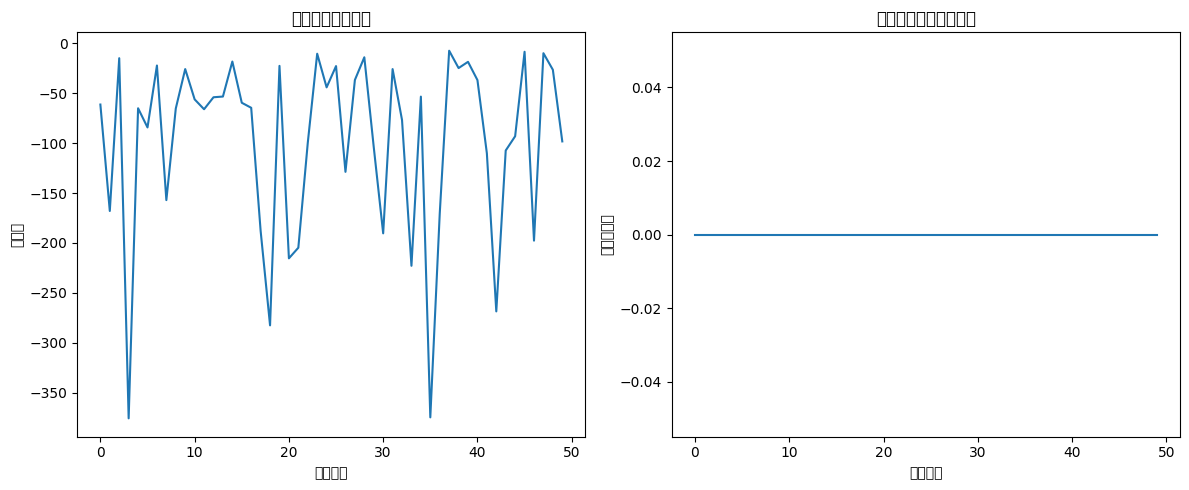


开始测试...
测试结果 - 总奖励: -78.57, 完成任务数: 0

决策分析示例:
基础效用:
  任务 T1: 5.00
  任务 T2: 5.00
  任务 T3: 4.00
调整后效用:
  任务 T1: 5.01
  任务 T2: 4.98
  任务 T3: 4.01
任务选择概率:
  任务 T1: 0.4045
  任务 T2: 0.3756
  任务 T3: 0.2199
选择的任务: T1


In [36]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt

# 1. 创建仓库环境
env = WarehouseEnvironment()

# 2. 训练过程
num_episodes = 50
rewards_history = []
tasks_completed_history = []

print("开始训练...")
for episode in range(num_episodes):
    # 重置环境
    env = WarehouseEnvironment()
    
    # 运行一个完整的仿真周期
    total_reward, completed_tasks = env.run_episode()
    
    # 记录结果
    rewards_history.append(total_reward)
    tasks_completed_history.append(completed_tasks)
    
    # 输出进度
    if (episode + 1) % 5 == 0:
        print(f"Episode {episode+1}/{num_episodes}, 奖励: {total_reward:.2f}, 完成任务数: {completed_tasks}")

# 3. 可视化训练结果
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title('每轮仿真的总奖励')
plt.xlabel('仿真轮次')
plt.ylabel('总奖励')

plt.subplot(1, 2, 2)
plt.plot(tasks_completed_history)
plt.title('每轮仿真完成的任务数')
plt.xlabel('仿真轮次')
plt.ylabel('完成任务数')

plt.tight_layout()
plt.show()

# 4. 测试训练好的模型
test_env = WarehouseEnvironment()
# 将训练好的经理智能体参数复制到测试环境
test_env.manager.load_state_dict(env.manager.state_dict())

print("\n开始测试...")
test_reward, test_completed = test_env.run_episode()
print(f"测试结果 - 总奖励: {test_reward:.2f}, 完成任务数: {test_completed}")

# 5. 分析决策过程 (示例)
print("\n决策分析示例:")
# 创建一些示例任务
example_tasks = [
    {'id': 'T1', 'nest': 'A', 'location': (10, 15), 'features': np.random.random(5), 'priority': 3, 'create_time': 0},
    {'id': 'T2', 'nest': 'A', 'location': (25, 30), 'features': np.random.random(5), 'priority': 2, 'create_time': 0},
    {'id': 'T3', 'nest': 'B', 'location': (5, 20), 'features': np.random.random(5), 'priority': 4, 'create_time': 0}
]

# 获取当前状态
current_state = test_env.get_state()

# 分类任务
tasks_by_nest = {'A': [], 'B': []}
for task in example_tasks:
    tasks_by_nest[task['nest']].append(task['id'])

# 计算基础效用
base_utilities = test_env.manager.compute_base_utilities(example_tasks)
print("基础效用:")
for task_id, utility in base_utilities.items():
    print(f"  任务 {task_id}: {utility:.2f}")

# 通过RL调整效用
adjusted_utilities = test_env.manager.adjust_utilities(current_state, base_utilities, example_tasks)
print("调整后效用:")
for task_id, utility in adjusted_utilities.items():
    print(f"  任务 {task_id}: {utility:.2f}")

# 使用嵌套Logit计算任务选择概率
task_probs = test_env.manager.nl_model.compute_task_probabilities(
    {nest: [t['id'] for t in example_tasks if t['nest'] == nest] for nest in ['A', 'B']}, 
    adjusted_utilities
)
print("任务选择概率:")
for task_id, prob in task_probs.items():
    print(f"  任务 {task_id}: {prob:.4f}")

# 选择任务
selected_task = test_env.manager.select_task(current_state, example_tasks)
print(f"选择的任务: {selected_task}")

In [38]:
# 简化的WarehouseEnvironment，专注于修复任务完成问题
class SimpleWarehouseEnvironment:
    def __init__(self):
        """初始化简化版仓库环境"""
        self.time = 0
        self.tasks = []
        self.picker = PickerAgent(picker_id="P1")
        self.completed_tasks = []
        self.task_id_counter = 0
        self.debug = True  # 打开调试输出
        
    def generate_task(self):
        """生成新任务"""
        task_id = f"T{self.task_id_counter}"
        self.task_id_counter += 1
        
        # 随机决定任务类型
        nest = np.random.choice(['A', 'B'], p=[0.7, 0.3])
        
        # 随机生成任务位置和其他属性
        location = (np.random.randint(0, 10), np.random.randint(0, 10))
        
        task = {
            'id': task_id,
            'nest': nest,
            'location': location,
            'priority': np.random.randint(1, 6),
            'create_time': self.time
        }
        
        self.tasks.append(task)
        if self.debug:
            print(f"生成任务: {task_id}, 类型: {nest}")
        return task
        
    def step(self, timestep=300):  # 增加步长到5分钟
        """环境前进一步"""
        # 更新时间
        self.time += timestep
        
        # 随机生成新任务
        if np.random.random() < 0.7:  # 增加生成概率
            self.generate_task()
            
        # 检查拣选员是否空闲
        if self.picker.is_idle(self.time) and self.tasks:
            if self.debug:
                print(f"时间 {self.time}: 拣选员空闲，待处理任务数: {len(self.tasks)}")
            
            # 简单选择第一个任务
            assigned_task = self.tasks.pop(0)
            
            # 分配给拣选员
            completion_time = self.picker.assign_task(assigned_task, self.time)
            
            if self.debug:
                print(f"分配任务 {assigned_task['id']} 给拣选员，预计完成时间: {completion_time}")
        
        # 关键修复：检查任务是否完成
        if not self.picker.is_idle(self.time - timestep) and self.time >= self.picker.busy_until:
            completed_task = self.picker.complete_task(self.time)
            if completed_task:
                self.completed_tasks.append(completed_task)
                if self.debug:
                    print(f"时间 {self.time}: 完成任务 {completed_task['id']}")
        
        # 简化奖励：每完成一个任务+10分
        reward = len(self.completed_tasks) * 10
        
        # 检查是否结束
        done = self.time >= 8 * 3600  # 8小时
            
        return reward, done
            
    def run_episode(self, max_steps=100, timestep=300):
        """运行一个完整的仿真周期"""
        if self.debug:
            print("开始新的模拟周期")
            
        total_reward = 0
        for step in range(max_steps):
            reward, done = self.step(timestep=timestep)
            total_reward = reward  # 使用累计完成数作为奖励
            
            if self.debug and step % 10 == 0:
                print(f"步骤 {step}, 时间: {self.time/3600:.1f}小时, 完成任务: {len(self.completed_tasks)}")
                
            if done:
                break
                
        if self.debug:
            print(f"模拟结束，总时间: {self.time/3600:.1f}小时, 完成任务总数: {len(self.completed_tasks)}")
            
        return total_reward, len(self.completed_tasks)

In [39]:
class SimplePickerAgent:
    def __init__(self, picker_id):
        """初始化简化版拣选员"""
        self.id = picker_id
        self.current_task = None
        self.position = (0, 0)
        self.busy_until = 0
        
    def is_idle(self, current_time):
        """判断拣选员是否空闲"""
        return current_time >= self.busy_until
        
    def assign_task(self, task, current_time):
        """分配任务给拣选员"""
        self.current_task = task
        
        # 简化的任务时长计算
        base_time = 600  # 10分钟基础时间
        if task['nest'] == 'B':
            base_time *= 1.5  # 特殊任务耗时更长
            
        # 简化的距离计算
        distance = abs(self.position[0] - task['location'][0]) + abs(self.position[1] - task['location'][1])
        travel_time = distance * 60  # 每单位距离1分钟
        
        # 设置忙碌截止时间
        duration = base_time + travel_time
        self.busy_until = current_time + duration
        
        return self.busy_until
    
    def complete_task(self, current_time):
        """完成当前任务"""
        if self.current_task and current_time >= self.busy_until:
            completed_task = self.current_task
            self.position = completed_task['location']  # 更新位置
            self.current_task = None
            return completed_task
        return None

In [40]:
# 测试简化版环境
simple_env = SimpleWarehouseEnvironment()
reward, completed = simple_env.run_episode()
print(f"简化版测试结果 - 奖励: {reward}, 完成任务数: {completed}")

开始新的模拟周期
生成任务: T0, 类型: A
时间 300: 拣选员空闲，待处理任务数: 1
分配任务 T0 给拣选员，预计完成时间: 392
步骤 0, 时间: 0.1小时, 完成任务: 0
生成任务: T1, 类型: B
时间 600: 拣选员空闲，待处理任务数: 1
分配任务 T1 给拣选员，预计完成时间: 716.0
生成任务: T2, 类型: A
时间 900: 拣选员空闲，待处理任务数: 1
分配任务 T2 给拣选员，预计完成时间: 980
时间 1200: 完成任务 T2
生成任务: T3, 类型: B
时间 1500: 拣选员空闲，待处理任务数: 1
分配任务 T3 给拣选员，预计完成时间: 1596.0
生成任务: T4, 类型: A
时间 1800: 拣选员空闲，待处理任务数: 1
分配任务 T4 给拣选员，预计完成时间: 1870
生成任务: T5, 类型: A
时间 2100: 拣选员空闲，待处理任务数: 1
分配任务 T5 给拣选员，预计完成时间: 2162
时间 2400: 完成任务 T5
生成任务: T6, 类型: A
时间 2700: 拣选员空闲，待处理任务数: 1
分配任务 T6 给拣选员，预计完成时间: 2776
时间 3000: 完成任务 T6
生成任务: T7, 类型: A
时间 3300: 拣选员空闲，待处理任务数: 1
分配任务 T7 给拣选员，预计完成时间: 3368
步骤 10, 时间: 0.9小时, 完成任务: 3
生成任务: T8, 类型: A
时间 3600: 拣选员空闲，待处理任务数: 1
分配任务 T8 给拣选员，预计完成时间: 3662
生成任务: T9, 类型: B
时间 3900: 拣选员空闲，待处理任务数: 1
分配任务 T9 给拣选员，预计完成时间: 4002.0
时间 4200: 完成任务 T9
生成任务: T10, 类型: A
时间 4500: 拣选员空闲，待处理任务数: 1
分配任务 T10 给拣选员，预计完成时间: 4570
生成任务: T11, 类型: B
时间 4800: 拣选员空闲，待处理任务数: 1
分配任务 T11 给拣选员，预计完成时间: 4906.0
生成任务: T12, 类型: A
时间 5100: 拣选员空闲，待处理任务数: 1
分配任务 T12 给拣选员，预计完成时间

In [37]:
# ---------- 5. K-Means 空间巢 + Nested-Logit 经理分配 ----------
coords = slots[['x','y']].values
k = 8
clusters = KMeans(n_clusters=k, random_state=0).fit(coords)          #&#8203;:contentReference[oaicite:14]{index=14}
slots['cluster'] = clusters.labels_
orders['nest_id'] = (orders['eq_flag'].astype(str) + "_" +
                     RNG.choice(k, size=len(orders)).astype(str) + "_" +
                     pd.cut(orders['sla_sec'],
                            bins=[0,1800,3600,SIM_TIME],
                            labels=['F','N','L']).astype(str))


KeyError: 'eq_flag'

In [ ]:

# 简化 NL：巢概率 ~ 经验频率；巢内随机
nest_probs = orders['nest_id'].value_counts(normalize=True).to_dict()
assign_rows = []
for _, row in orders.iterrows():
    if RNG.random() < nest_probs[row['nest_id']]:          # 经理接受该巢
        picker = RNG.integers(0, N_PICKERS)                # 轮询可改HRL
        assign_rows.append({'order_id': row['order_id'],
                            'picker_id': f"P{picker}",
                            'assign_ts': row['create_ts'],
                            'picked_flag': 0})
assign = pd.DataFrame(assign_rows)

In [129]:
# ---------- 6. 拣选仿真 ----------
G = nx.grid_2d_graph(GRID_W, GRID_H)                       #&#8203;:contentReference[oaicite:15]{index=15}
env = simpy.Environment()
inv      = slots.set_index('slot_id')['quantity'].to_dict()
pick_log = []
def heuristic(a,b): return abs(a[0]-b[0]) + abs(a[1]-b[1])

def picker_proc(env, pid, job_q):
    while True:
        if job_q:
            oid = job_q.pop(0)
            order = orders.loc[orders.order_id==oid].iloc[0]
            # 找到各 SKU 的 slot
            route = []
            for sku in order.sku_list:
                # 筛选出包含当前 sku 的货位
                possible_slots = slots.loc[slots.sku == sku]
                # 检查是否有找到对应的货位
                if not possible_slots.empty:
                    # 如果找到了，从中随机抽取一个
                    slot_id = possible_slots.sample(1, random_state=RNG).iloc[0]['slot_id']
                    route.append(slot_id)
                else:
                    # 如果没找到，需要决定如何处理
                    # 选项 1: 跳过这个 SKU
                    print(f"警告：SKU '{sku}' 在 'slots' 中没有找到对应的货位，已跳过。")
                    # 选项 2: 抛出更明确的错误
                    # raise ValueError(f"错误：SKU '{sku}' 在 'slots' 中没有找到对应的货位。请检查数据一致性。")
                    # 选项 3: 执行其他逻辑...
                    pass # 当前示例选择跳过
                slot_id = slots.loc[slots.sku==sku].sample(1, random_state=RNG).iloc[0]['slot_id']
                route.append(slot_id)
            # 简单最近邻排序（可替换TSP）
            cur = (0,0)
            for sid in route:
                target = (int(slots.loc[sid,'x']), int(slots.loc[sid,'y']))
                path = nx.astar_path(G, cur, target, heuristic=heuristic)
                for node in path[1:]:
                    yield env.timeout(WALK_SPEED)
                    pick_log.append((pid, env.now, node[0], node[1], 0))
                # pick action
                yield env.timeout(PICK_TIME)
                inv[sid] -= 1
                cur = target
            # 装车
            yield env.timeout(LOAD_TIME)
        else:
            yield env.timeout(1)

job_queues = {f"P{i}":[] for i in range(N_PICKERS)}
for _, a in assign.iterrows():
    job_queues[a.picker_id].append(a.order_id)
for pid in job_queues:
    env.process(picker_proc(env, pid, job_queues[pid]))
env.run(until=SIM_TIME)

picks = pd.DataFrame(pick_log, columns=['picker_id','step_ts','x','y','load'])
slots['quantity'] = slots.index.map(inv.get)
slots.to_csv("inventory_end.csv", index=False)
orders.to_csv("orders.csv",   index=False)
assign.to_csv("assign.csv",   index=False)
picks.to_csv("picks.csv",     index=False)
print("Synthetic data generated ✓")


NameError: name 'GRID_W' is not defined